# Simple ARIMA Model for Non-Seasonal Time-Series Forecast

Our goal in this challenge is to apply the basic concepts of time series analysis to one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the Time Series of the challenge. Run the line below to download the dataset as a CSV file, then load the CSV in a DataFrame.

In [1]:
!curl https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/www_usage.csv > data/www_usage.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0   1547      0 --:--:-- --:--:-- --:--:--  1570


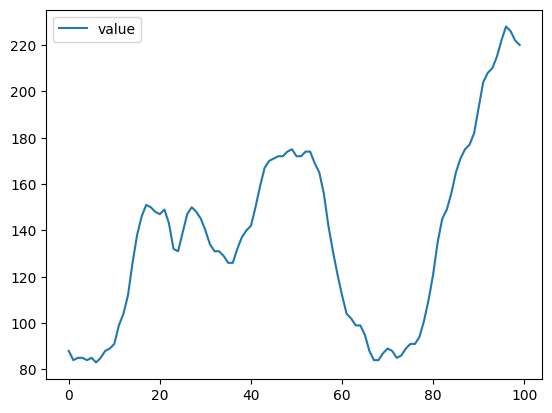

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value

df.plot();


This abstract time series does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regressive Moving Average (ARIMA) models.


## 2. Build ARIMA Model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time series (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the moving average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure Stationarity

ARIMA models apply to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y)

adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

if p_value <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


ADF Statistic: -2.4642397172033697
p-value: 0.12441935447109442
The time series is likely non-stationary.


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat the process on the differentiated series if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

ADF p-value (original series): 0.12441935447109442
ADF p-value (first difference): 0.07026846015272718
ADF p-value (second difference): 2.843428755547158e-17


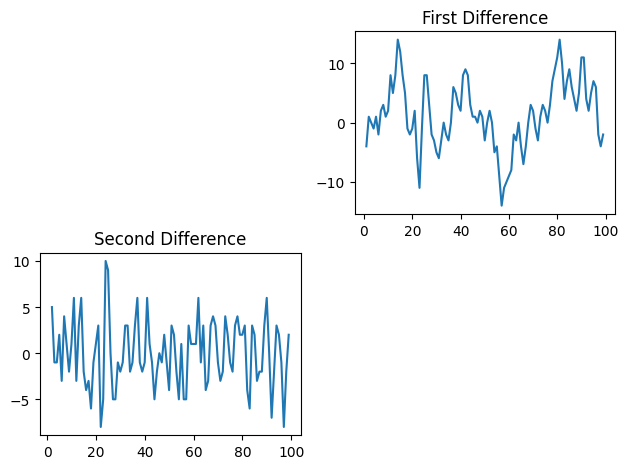

In [4]:
result_original = adfuller(y)
p_value_original = result_original[1]
print(f'ADF p-value (original series): {p_value_original}')

plt.subplot(2, 2, 2)
y_diff1 = y.diff().dropna()
plt.plot(y_diff1)
plt.title('first difference')

result_diff1 = adfuller(y_diff1)
p_value_diff1 = result_diff1[1]
print(f'ADF p-value (first difference): {p_value_diff1}')

plt.subplot(2, 2, 3)
y_diff2 = y_diff1.diff().dropna()
plt.plot(y_diff2)
plt.title('second difference')

result_diff2 = adfuller(y_diff2)
p_value_diff2 = result_diff2[1]
print(f'ADF p-value (second difference): {p_value_diff2}')

plt.tight_layout()
plt.show()


We have a close call here between one and two diff orders. Differentiating time series too much may also reduce the performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

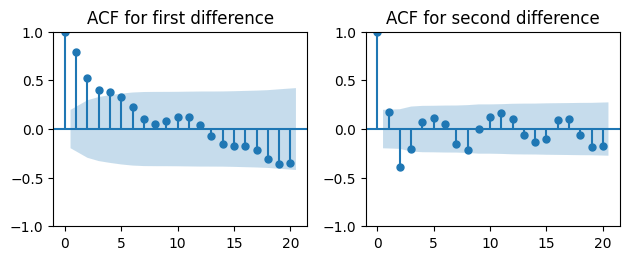

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plt.subplot(2, 2, 1)
plot_acf(y_diff1, ax=plt.gca())
plt.title('ACF for first difference')

plt.subplot(2, 2, 2)
plot_acf(y_diff2, ax=plt.gca())
plt.title('ACF for second difference')

plt.tight_layout()
plt.show()


In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (tentatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [8]:
y_diff = y.diff().dropna()


We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary ("I" refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


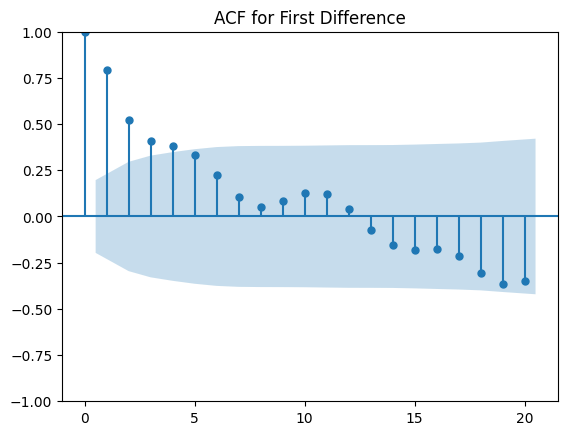

In [9]:
plt.subplot(1, 1, 1)
plot_acf(y_diff1, ax=plt.gca())
plt.title('ACF for first difference')

plt.show()


The maximum value we should consider for fitting our model seems to be q = 4. However, if we were to use Auto-ARIMA (more on this later) we would find that using q=2 yields ideal results so to begin with, let's try setting q=2. 

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


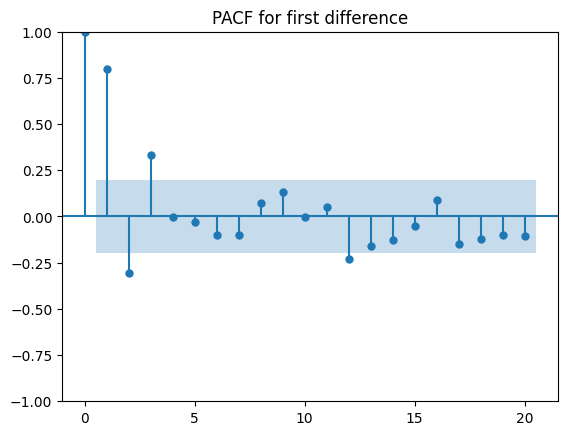

In [11]:
plt.subplot(1, 1, 1)
plot_pacf(y_diff1, ax=plt.gca())
plt.title('PACF for first difference')

plt.show()


We could choose `p = 3` as the first 3 lag terms seem above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d`, and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the model
- print the model (`.summary`)

In [12]:
from statsmodels.tsa.arima.model import ARIMA

p = 1
d = 1
q = 1

arima_model = ARIMA(y, order=(p, d, q))
arima_result = arima_model.fit()

print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Thu, 16 Nov 2023   AIC                            514.300
Time:                        10:35:10   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.0

☝️ If your p-values are too high, try to remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate the overall performance of your fit by minimizing the [`AIC - Akaike Information Criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remain low) and maintain a quasi-similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with the `plot_predict()` method

- Look closely at the method default params, especially `dynamic` ones. 
- Do you think your model would have such a good performance in reality?

In [13]:
from statsmodels.graphics.tsaplots import plot_predict


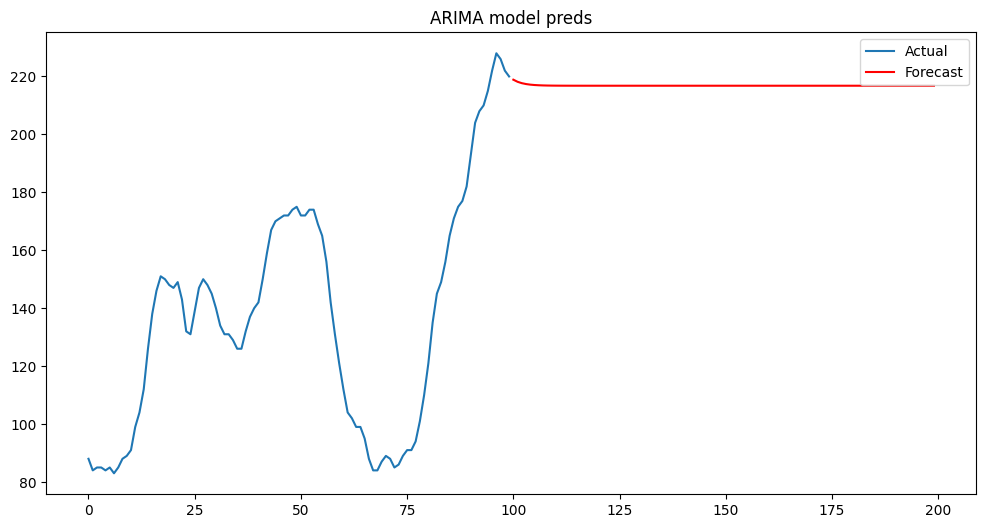

In [17]:
forecast = arima_result.get_forecast(steps=len(y))

forecast_values = forecast.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual')
plt.plot(range(len(y), len(y) + len(forecast_values)), forecast_values, color='red', label='Forecast')
plt.title('ARIMA model preds')
plt.legend()
plt.show()


☝️ `dynamic=False` makes use of all available values `y` to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prediction of the _last 15 values_ in a situation where the model only has _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ its previously predicted value for 86
- etc...iteratively until 100

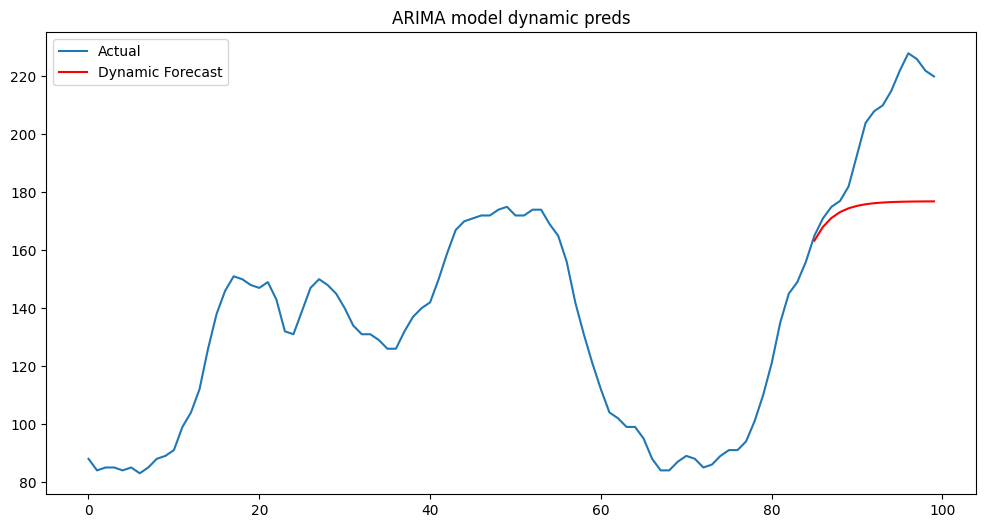

In [19]:
num_steps = 15

start_point = len(y) - num_steps

pred_dynamic = arima_result.get_prediction(start=start_point, dynamic=True)

pred_values_dynamic = pred_dynamic.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual')
plt.plot(range(start_point, start_point + len(pred_values_dynamic)), pred_values_dynamic, color='red', label='Dynamic Forecast')
plt.title('ARIMA model dynamic preds')
plt.legend()
plt.show()


☝️ That's still not a _true_ forecast! Why?

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` series during the fitting phase!
</details>

### 3.1 Out-of-Sample Forecasts (real "future")

👉 Create a train-test-split keep the last 15 data points only for the test set, and train your ARIMA on the train set only.

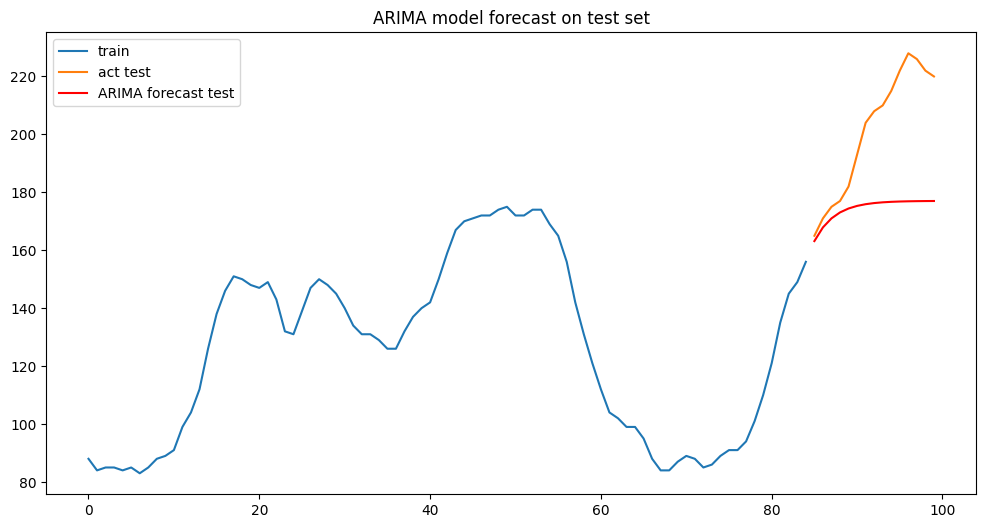

In [20]:
test_size = 15

train = y[:-test_size]
test = y[-test_size:]

arima_model_train = ARIMA(train, order=(p, d, q))
arima_result_train = arima_model_train.fit()

forecast_test = arima_result_train.get_forecast(steps=test_size)

forecast_values_test = forecast_test.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(train, label='train')
plt.plot(test.index, test, label='act test')
plt.plot(test.index, forecast_values_test, color='red', label='ARIMA forecast test')
plt.title('ARIMA model forecast on test set')
plt.legend()
plt.show()


👉 We are "now" in step 85 and have never seen the future:
- Use the `get_forecast()` method on your fitted `arima` model to "forecast" the 15 next data points (i.e beyond the end of your train dataset) 

The method returns a `PredictionResultsWrapper` object from `statsmodels`.

**💻 Store this result in a variable named `forecast_results`.**  

It is hard to navigate at first, but here are some tips:
- You can find your forecasts in `forecast_results.predicted_mean`
- Your confidence intervals are given by `forecast_results.conf_int()`

In [22]:
forecast_steps = 15

forecast_results = arima_result.get_forecast(steps=forecast_steps)

forecast_values_future = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

print("forecasted values:")
print(forecast_values_future)
print("\nconfidence intervals:")
print(confidence_intervals)


forecasted values:
100    218.880504
101    218.152418
102    217.678892
103    217.370925
104    217.170632
105    217.040367
106    216.955647
107    216.900548
108    216.864713
109    216.841407
110    216.826249
111    216.816391
112    216.809980
113    216.805810
114    216.803098
Name: predicted_mean, dtype: float64

confidence intervals:
     lower value  upper value
100   212.746913   225.014095
101   203.464007   232.840828
102   194.417299   240.940484
103   185.973089   248.768760
104   178.206904   256.134360
105   171.086748   262.993987
106   164.544788   269.366506
107   158.506433   275.294662
108   152.901797   280.827629
109   147.669566   286.013248
110   142.757606   290.894892
111   138.122258   295.510524
112   133.727190   299.892770
113   129.542207   304.069414
114   125.542166   308.064030


👉 Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

👉 Try to also plot your previous 85 `y` real data points to better grasp model performance relative to the past

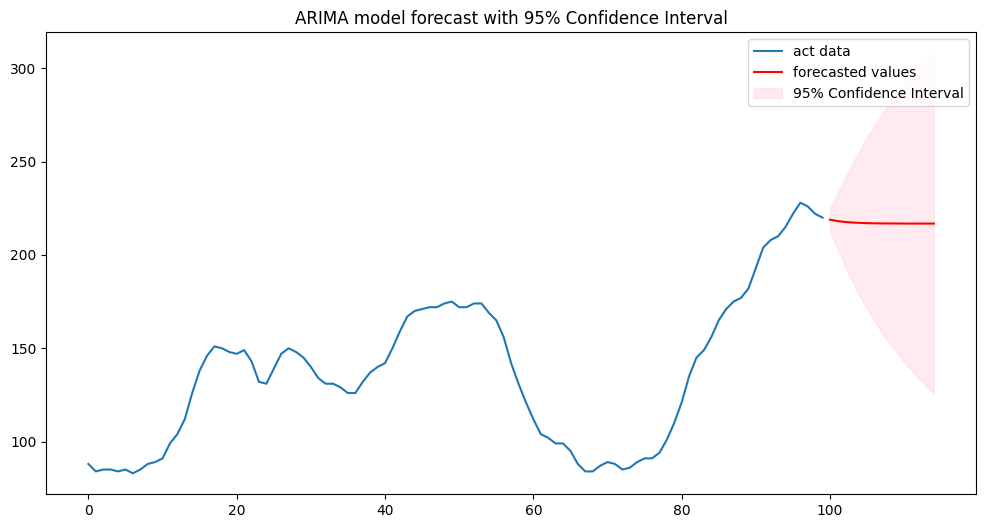

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y.index, y, label='act data')
plt.plot(forecast_values_future.index, forecast_values_future, color='red', label='forecasted values')
plt.fill_between(
    forecast_values_future.index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title('ARIMA model forecast with 95% Confidence Interval')
plt.legend()
plt.show()


### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals anyway if you want)

Note: residuals are constructed by 'seeing' all data as in `plot_predict(dynamic=False)`

Also, try to plot a histogram or KDE fit of the residuals to see if they are approximately normally distributed.

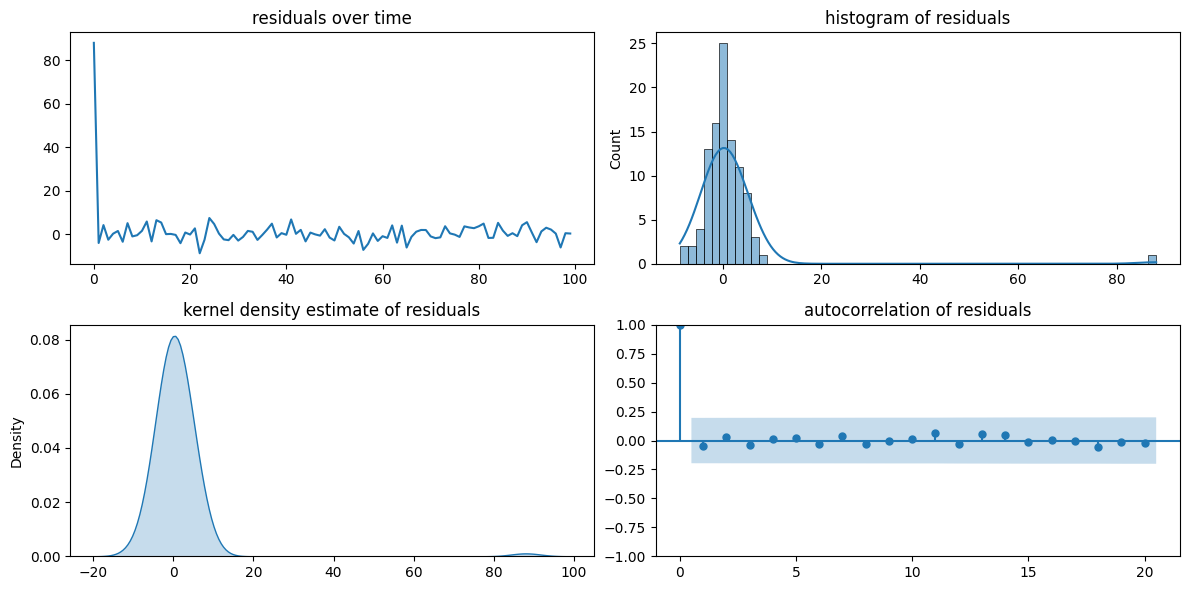

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

residuals = arima_result.resid

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.title('residuals over time')

plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('histogram of residuals')

# KDE plot of residuals
plt.subplot(2, 2, 3)
sns.kdeplot(residuals, fill=True)
plt.title('kernel density estimate of residuals')

# Autocorrelation plot of residuals
plt.subplot(2, 2, 4)
plot_acf(residuals, ax=plt.gca(), lags=20)
plt.title('autocorrelation of residuals')

plt.tight_layout()
plt.show()


## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [25]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast


👉 Play with your ARIMA hyper-parameters and see the impact on your forecast performance

In [26]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

results = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            arima_model = ARIMA(train, order=(p, d, q))
            arima_result = arima_model.fit()

            forecast_test = arima_result.get_forecast(steps=test_size)

            forecast_values_test = forecast_test.predicted_mean

            accuracy_metrics = forecast_accuracy(y_pred=forecast_values_test, y_true=test)

            result_entry = {
                'p': p,
                'd': d,
                'q': q,
                **accuracy_metrics
            }
            results.append(result_entry)

results_df = pd.DataFrame(results)

print(results_df)


/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3

    p  d  q      mape         me        mae       mpe       rmse      acf1  \
0   0  0  0  0.367518 -75.435299  75.435299 -0.367518  78.384380  0.842684   
1   0  0  1  0.361388 -74.435118  74.435118 -0.361388  78.021630  0.760149   
2   0  0  2  0.353219 -73.043389  73.043389 -0.353219  77.426879  0.738982   
3   0  1  0  0.215462 -45.200000  45.200000 -0.215462  49.966656  0.842684   
4   0  1  1  0.192961 -40.725771  40.725771 -0.192961  45.958842  0.842684   
5   0  1  2  0.160740 -34.271156  34.271156 -0.160740  40.150242  0.856992   
6   1  0  0  0.233880 -49.074636  49.074636 -0.233880  54.294555  0.840738   
7   1  0  1  0.218314 -46.075065  46.075065 -0.218314  51.996445  0.839746   
8   1  0  2  0.204571 -43.537868  43.537868 -0.204571  50.673362  0.849927   
9   1  1  0  0.112266 -23.971276  23.971276 -0.112266  28.365647  0.871778   
10  1  1  1  0.125222 -26.871495  26.871495 -0.125222  32.382382  0.871440   
11  1  1  2  0.116639 -25.042874  25.042874 -0.116639  30.264518

/Users/reecepalmer/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## 4 Grid Search

Try to run a Grid Search for (p,d,q) using `pmdarima`. Use at least
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [28]:
import pmdarima as pm

model = pm.auto_arima(
    train,            # Replace with your training data
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,           # let the model determine 'd'
    test='adf',       # using adf test to find the optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=449.662, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=449.569, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=445.819, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=445.820, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.300, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=438.613, Time=0.04 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=440.036, Time=0.02 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.01 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 0.318 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -215.307
Date:                Thu, 16 Nov 2023   AIC                   

## (Optional) Cross-validate the Performance of your Model

In practice, results and Grid Search should always be cross-validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create contiguous K-folds to truly evaluate the performance of your model and find the best hyperparams after cross-validation.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - Cross-Validation using TimeSeriesSplit + Grid Search**

In [32]:
# YOUR CODE HERE


In [33]:
df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()


KeyError: 'AIC'

☝️ Our initial choice of model (1, 1, 2) is not so bad!
Notice that the dataset (100 data points) is in reality way too small to cross-validate anything!